In [1]:
import pandas as pd
import numpy as np

In [2]:
from litreading.grade import DataGrader, grade_wcpm
from litreading.train import ModelTrainer
from litreading.config import SEED

## 1. Open Data as pandas dataframe

In [39]:
df = pd.read_csv("./data/larger_wcpm.csv")
df.head()

,human_wcpm,human_transcript,asr_transcript,prompt,scored_duration
0,107,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,every night at bedtime ben told stories to his...,60.0
1,128,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0
2,88,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,60.0
3,109,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0
4,127,last summer my daddy went wait no last summer ...,last summer my daddy went to last summer my da...,last summer my daddy sent me to the store for ...,60.0


## 2. Predict grades based on already trained models

### 2.1 With function

In [6]:
grades = grade_wcpm(df.loc[:50])
grades.head()

2020-10-13 10:12:10,269 root         INFO     Loading model from ./litreading/models/standard_scaler.joblib
2020-10-13 10:12:10,272 root         INFO     Loading model from ./litreading/models/XGB.joblib


,human_wcpm,human_transcript,asr_transcript,prompt,scored_duration,wcpm_estimation
0,107,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,every night at bedtime ben told stories to his...,60.0,100.0
1,128,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,126.1
2,88,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,60.0,89.8
3,109,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,111.7
4,127,last summer my daddy went wait no last summer ...,last summer my daddy went to last summer my da...,last summer my daddy sent me to the store for ...,60.0,126.7


### 2.2 Instanciate DataGrader

In [8]:
grader = DataGrader(df.loc[:50],  # mandatory
                    model_type='XGB',  # optional, default XGB
                    prompt_col='prompt',  # optional, default 'prompt'
                    asr_col='asr_transcript',  # optional, default 'asr_transcript'
                    duration_col='scored_duration',  # optional, default 'scored_duration'
                   )


2020-10-13 10:17:13,696 root         INFO     Loading model from ./litreading/models/standard_scaler.joblib
2020-10-13 10:17:13,698 root         INFO     Loading model from ./litreading/models/XGB.joblib


#### Option 1: use grade_wcpm method
Same as using grade_wcpm function, but you have access to the DataGrader instance after if you want to modify something

In [11]:
grades = grader.grade_wcpm(only_wcpm=False)  # optional, default False. If True, returns only the wcpm estimation
grades[['prompt', 'asr_transcript', 'human_wcpm', 'wcpm_estimation']].head()

,prompt,asr_transcript,human_wcpm,wcpm_estimation
0,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,107,100.0
1,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,128,126.1
2,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,88,89.8
3,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,109,111.7
4,last summer my daddy sent me to the store for ...,last summer my daddy went to last summer my da...,127,126.7


#### Option 2: step-by-step grading to choose different options such as preprocessing steps

Default preprocessing steps are specified in the `config.py` file. Hence they will be used by default for both prediction and training if need be.

In [13]:
grader.preprocess_data(lowercase=True,  # optional, default True
                       punctuation_free=True,  # optional, default True
                       convert_num2words=True,  # optional, default True
                       asr_string_recomposition=False,  # optional, default False
                       inplace=True  # optional, default False
                      )

grader.compute_features(inplace=True)  # optional, default False
grades = grader.estimate_wcpm(inplace=False)  # optional, default False

0    100.0
1    126.1
2     89.8
3    111.7
4    126.7
Name: wcpm_estimation, dtype: float64

Retrieve only the grades:

In [ ]:
grades.head()

Retrieve the whole dataframe:

In [14]:
grader.get_data().head()

,human_wcpm,human_transcript,asr_transcript,prompt,scored_duration,wcpm_estimation
0,107,every night at bedtime ben told stories to his...,bigfoot every night at bedtime ben told storie...,every night at bedtime ben told stories to his...,60.0,100.0
1,128,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,126.1
2,88,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,today's the big day said ruth what big day ask...,60.0,89.8
3,109,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,once upon a time there was an elephant who liv...,60.0,111.7
4,127,last summer my daddy went wait no last summer ...,last summer my daddy went to last summer my da...,last summer my daddy sent me to the store for ...,60.0,126.7


In [30]:
i = 50



print(grades['prompt'].loc[i])
print('\n')
print(grades['asr_transcript'].loc[i])
print('\n')
print(grades['scored_duration'].loc[i])
print(grades['wcpm_estimation'].loc[i])
print(grades['human_wcpm'].loc[i])

whee the small bat did a double backflip and landed neatly on the branch below did you see me uncle marlon alf squeaked be quiet button up kiddo we've got company he stared into the night the small bat's eyes widened the witches oh uncle marlon can i stay and watch will they do scary spells they're no big deal kiddo the older bat settled back on his branch deep magic's not allowed in the five kingdoms these witches are shallow through and through couldn't magic a bird off a branch but keep mum all the same you don't want to end up in a pot the small bat shivered okey dokey uncle m and he froze into stillness as he watched the line of women all dressed in black making their way into the clearing at the top of the hill limping at the end of the line was the small skinny figure of a girl her head bent tenderly over the bundle in her arms as the witches hurried here and there collecting firewood and setting up the black cauldron she slipped away and settled herself at the foot of the tree 

## 3. Train a model

### 3.1 Train a model with default params

#### 3.1.a Instanciate
Instanciate ModelTrainer and preprocess the data. You have to choose several parameters that are all listed here. You have to choose between Random Forest ('RF'), XGBoost('XGB') and K nearest neighbors ('KNN'). You will be able to change it after without re processing the data using the set_new_model(model_type, params) method.

In [17]:
config = {
    'model_type': 'Baseline',  # available: 'Baseline', 'RF', 'KNN', 'XGB'
    'remove_outliers': True,
    'outliers_tol': .15,  # default is .2
    'test_set_size': .2,
    'seed': SEED
}

# Instanciate the trainer
trainer = ModelTrainer(df,  # mandatory
                       model_type = config['model_type']  # optional, default 'XGB'
                      )

#### 3.1.b Training and test sets and feature computation
Prepare the training and test sets. You have the choice to remove outliers or not. Here, outliers are defined as data points where the number of words in th asr transcript and the human transcript defer by more than `outliers_tol` in percentage. 

e.g.: 100 words in asr transcript, 115 in human transcript: absolute difference of 15%. The datapoint will be removed with `outliers_tol=.1`, kept with `outliers_tol=.2`

In [19]:
trainer.prepare_train_test_set(remove_outliers=config['remove_outliers'],  # optional, default False
                               outliers_tol=config['outliers_tol'],  # optional, default .2, used if remove_outliers=True,
                               test_set_size=config['test_set_size'],  # optional, default .2
                               inplace=True  # optional, default True
                              )

2020-10-13 10:39:06,507 root         INFO     Removed 166 outliers, 2876 datapoints remaining for training/testing


Take a look at the features used to estimate the wcpm (after standard scaling), plus label 'human_wc':

In [20]:
trainer.features.describe()

,correct_words_pm,added_words_pm,removed_words_pm,replaced_words_pm,asr_word_count_pm,prompt_avg_word_length,prompt_std_word_length,asr_avg_word_length,asr_std_word_length,human_wcpm
count,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,107.682377,9.626946,11.225832,3.795793,117.619406,4.217915,1.969704,4.129150,1.882962,109.109875
std,36.296089,6.614929,24.599078,3.765989,36.515448,0.513844,0.369361,0.536421,0.359985,37.148994
min,0.000000,0.000000,0.000000,0.000000,0.803732,2.357000,0.667000,2.000000,0.000000,0.000000
25%,85.000000,5.000000,2.000000,1.000000,95.582619,4.040000,1.855000,3.914750,1.691750,86.000000
50%,112.000000,8.302016,4.553308,3.000000,122.000000,4.258000,1.993000,4.179000,1.935000,113.000000
75%,133.000000,13.000000,10.000000,5.000000,142.000000,4.523000,2.229000,4.440000,2.114250,134.250000
max,219.591194,78.000000,284.654213,41.000000,253.000000,5.207000,2.757000,5.429000,2.985000,259.000000


#### 3.1.c Training
All models default parameters are in the `config.py` file . Therefore, you need not give any parameter to train the model.

In [21]:
trainer.train()

2020-10-13 10:39:06,592 root         INFO     Training Baseline


#### 3.1.d Evaluate the model
Evaluate the model by getting 3 dataframes:
- stats with all statistics for all datapoints
- summary with statistics like MAE, MAE%, RMSE divided in 3 bins of data per human_wcpm value: -75 words, 75-150, 150+
- errors with count and % or errors > 1%, 5%, 10% for the 3 bins of data.

You can specify `visualize=True` if you want to have a graph of error distribution. An alternative it to call later `grader.plot_wcpm_distribution()`.

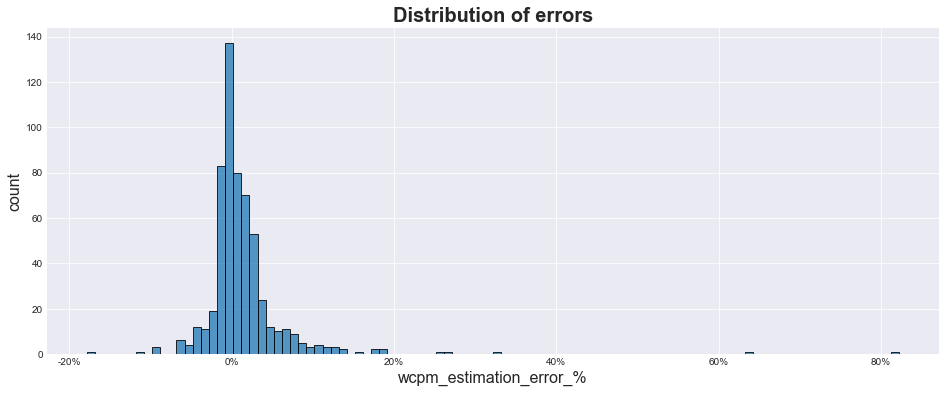

In [24]:
stats, summary, errors = trainer.evaluate_model(visualize=True)  # default is True for visualize

In [25]:
stats.head()

,wcpm_estimation,human_wcpm,wcpm_estimation_error,wcpm_estimation_abs_error,wcpm_estimation_error_%,wcpm_estimation_abs_error_%,RMSE,wcpm_bin,Total Count,Error > 1%,Error > 5%,Error > 10%
24,129.000000,128,-1.000000,1.000000,-0.007812,0.007812,1.000000,75-150,True,False,False,False
2337,129.000000,130,1.000000,1.000000,0.007692,0.007692,1.000000,75-150,True,False,False,False
1528,139.000000,143,4.000000,4.000000,0.027972,0.027972,16.000000,75-150,True,True,False,False
222,53.339128,54,0.660872,0.660872,0.012238,0.012238,0.436752,<75,True,True,False,False
50,117.000000,117,0.000000,0.000000,0.000000,0.000000,0.000000,75-150,True,False,False,False


In [26]:
summary

wcpm_estimation_error        wcpm_estimation_abs_error         \
                          mean    std                      mean    std   
wcpm_bin                                                                 
150+                      6.80  14.39                      7.32  14.13   
75-150                    1.02   3.04                      2.11   2.41   
<75                       1.03   5.43                      2.45   4.94   
total                     1.67   6.18                      2.76   5.78   

         wcpm_estimation_abs_error_%           RMSE          
                                mean    std    mean     std  
wcpm_bin                                                     
150+                            4.02   6.73  250.11  975.93  
75-150                          1.89   2.13   10.28   31.53  
<75                             5.14  10.46   30.21  199.32  
total                           2.72   5.44   40.94  345.63

In [27]:
errors

Total Count          Error > 1%          Error > 5%           \
               count % of bin      count % of bin      count % of bin   
wcpm_bin                                                                
150+            65.0    100.0       37.0     56.9       16.0     24.6   
75-150         407.0    100.0      238.0     58.5       29.0      7.1   
<75            104.0    100.0       81.0     77.9       30.0     28.8   
total          576.0    100.0      356.0     61.8       75.0     13.0   

         Error > 10%           
               count % of bin  
wcpm_bin                       
150+             7.0     10.8  
75-150           4.0      1.0  
<75             14.0     13.5  
total           25.0      4.3

You can also visualize feature importance for Random Forests and boosting models. This method will raise an error if applied to a ModelTrainer instance currently using a BaselineModel or KNN model.

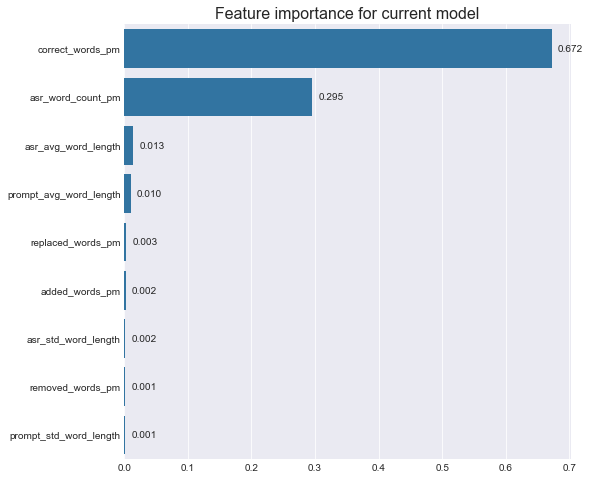

In [40]:
trainer.feature_importance()

#### 3.1.e Saving models

You can save models using the `trainer.save_models()` methods. You can choose what you want to save (scaler and / or model) and if you want to replace previous models or not (this will delete previous models of te same type). The saving directory is `MODELS_PATH` from `config.py`.

In [ ]:
trainer.save_model(scaler = False,  # default is False
                  model = True,  # default is False
                  replace = False  # default is False
                 )

### 3.2 Train a model and tune hyperparameters using grid search

Now we want to train another model and decide with what parameters. You can do so without having to redo the preprocesssing: we can use self.set_new_model() and specify both the model type and the params for the model. 

#### 3.2.a Specify model and parameters and train

In [35]:
# We will use RF here, but you can use any of the models and params listed below
# model_type = 'XGB'
# params = {'n_estimators': 800,
#           'learning_rate': 0.02,
#           'max_depth': 7,
#           'subsample': 0.8,
#           'colsample_bytree': 0.9,
#           'gamma': 5
#          }

# model_type = 'KNN'
# params = {'n_neighbors': 4,
#           'weights': 'distance'
#          }

model_type = 'RF'
params = {'max_features': 6,
          'n_estimators': 600,
          'max_depth': 10,
          'min_samples_split': 4,
          'min_samples_leaf': 1,
          'bootstrap': True
         }

# model_type = 'Baseline'
# params = {}

trainer.set_new_model(model_type=model_type,
                      params=params,
                      inplace=True
                     )

In [36]:
trainer.train()
stats, summary, errors = trainer.evaluate_model(visualize=False)

2020-10-13 10:56:39,463 root         INFO     Training RF


#### 3.2.b Visualization 
An alternative to `visualize=True` in `trainer.evaluate_model()` is to use `trainer.plot_wcpm_distribution`:

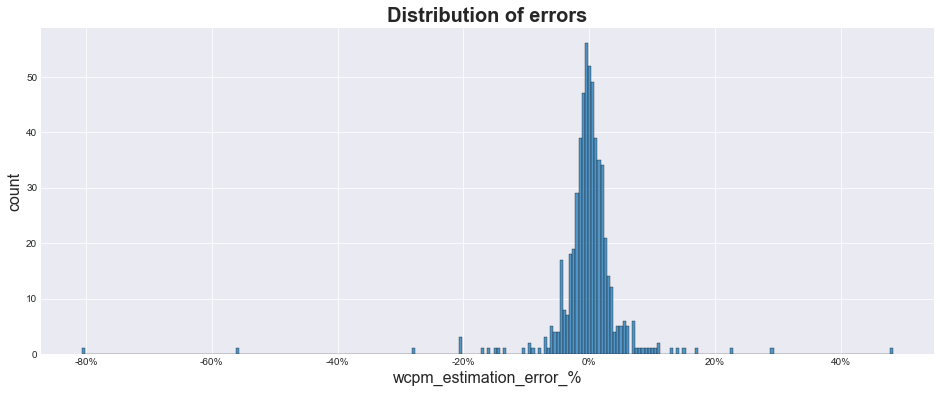

In [37]:
trainer.plot_wcpm_distribution(stats=stats,  # mandatory
                               x='wcpm_estimation_error_%',  # optional, default is 'wcpm_estimation_error_%'
                               stat='count',  # optional, default is 'count'
                               binwidth=.005, # optional, default is '.01'
                              )

You can also print a scatter plot of errors and wcpm estimatiosn to see where are the biggest errors and what is the performance of the model:

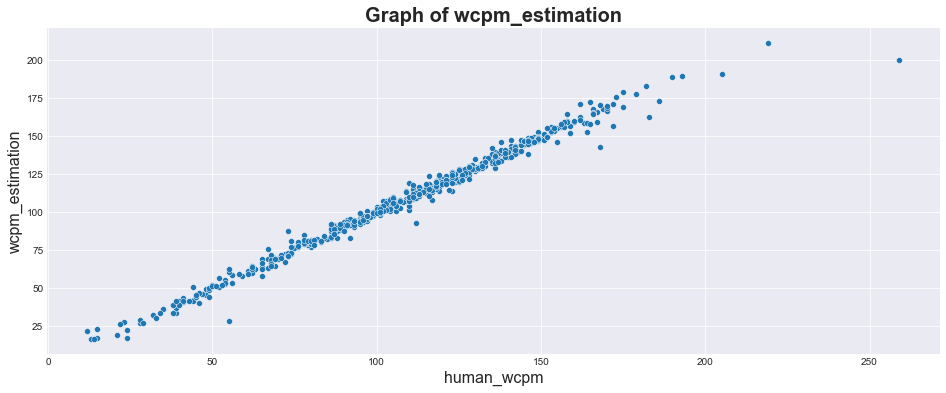

In [38]:
trainer.plot_wcpm_scatter(stats,  # mandatory
                          y = 'wcpm_estimation',  # optional, default 'wcpm_estimation_error_%'
                          x = 'human_wcpm'  # optional, default 'human_wcpm'
                         )

#### 3.2.c training the Baseline model

The Baseline model is implemeneted as a basic longest common subsequence using the Difflib package. The class BaselineModel is defined in `utils.py`.

2020-10-08 18:39:31,668 root         INFO     Training Baseline
2020-10-08 18:39:31,668 root         INFO     Training Baseline


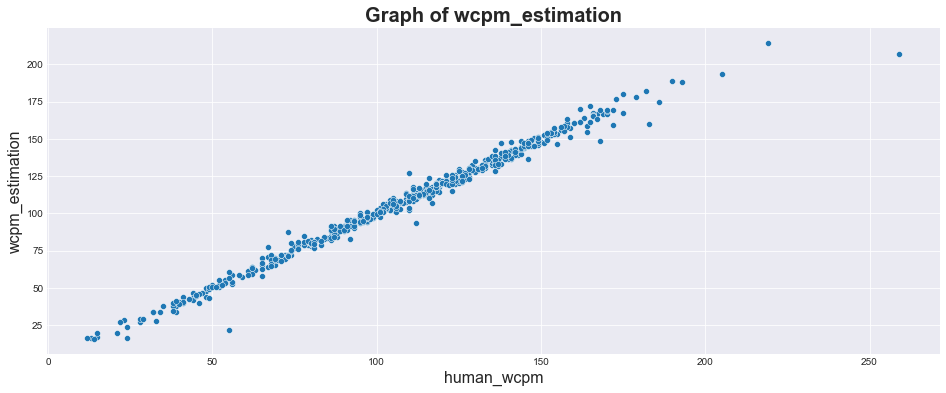

In [42]:
trainer.set_new_model(model_type = 'Baseline')
trainer.train()
trainer.plot_wcpm_scatter(stats, y = 'wcpm_estimation', x = 'human_wcpm')

## 4. Grid search

### 4.1 set parameters and model

In [ ]:
# RandomForestRegressor
model_type = 'RF'
cv_params={
#     'max_features': np.arange(1, 9, 1),
    'max_features': [6],
#     'n_estimators': list(np.arange(100, 2001, 100)),
    'n_estimators': [600],
#     'max_depth': np.arange(5, 120, 5),
#     'max_depth': np.arange(1, 20, 1)
    'max_depth': [10],
#     'min_samples_split': np.arange(1, 15, 1),
    'min_samples_split': [4],
#     'min_samples_leaf': np.arange(1, 6, 1)
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# XGBoostRegressors
# model_type = 'XGB'
# cv_params = {
# #     'n_estimators': list(np.arange(10, 100, 10)) + list(np.arange(100, 2001, 100)),
# #     'n_estimators': [200, 300, 400, 500, 600, 700, 1000],
#     'n_estimators': [200],
# #     'learning_rate': np.arange(0.0, 0.101, 0.005),
# #     'learning_rate': [0.01, 0.02, 0.04, 0.05, 0.1],
#     'learning_rate': [0.04],
# #     'max_depth': np.arange(3, 26, 1)
#     'max_depth': [5],
# #     'subsample': np.arange(0.6, 1, 0.01),
#     'subsample': [0.8],
# #     'colsample_bytree': np.arange(0.3, 1, 0.02),
# #     'colsample_bytree': [0.9],
# #     'gamma': [0, 1, 5]
#     'gamma': [0]
# }

# KNN
# model_type = 'KNN'
# cv_params = {
#     "n_neighbors": np.arange(1, 30, 1),
#     'weights': ['uniform', 'distance']
# }

### 4.2 Train and validate models

In [ ]:
gd = trainer.grid_search(model_type = model_type,
                         cv_params=cv_params,
                         cv_folds=5,
                         scoring_metric = 'r2',
                         verbose = 5
                        )

### 4.3 Visualize results

In [ ]:
print(gd.best_params_)
trainer.plot_grid_search(gd.cv_results_, x='n_estimators', hue=None, log_scale = False)

### 4.4 Select and save model